<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/python/chronos/colab-notebook/chronos_experimental_autots_nyc_taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

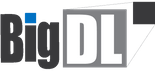

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install bigdl-chronos**

You can install the latest pre-release version with automl support using `pip install --pre --upgrade bigdl-chronos[all]`. 

In [ ]:
# Install latest pre-release version of bigdl-chronos 
# Installing bigdl-chronos from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-chronos[all]
exit() # restart the runtime to refresh installed pkg

## **Distributed automl for time series forecasting using Chronos AutoTS**

In this guide we will demonstrate how to use Chronos AutoTS for automated time seires forecasting in 5 simple steps.

## **Step 0: Prepare dataset**
We used NYC taxi passengers dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot.

In [ ]:
# download the dataset
!wget https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv

In [ ]:
# load the dataset. The downloaded dataframe contains two columns, "timestamp" and "value".
import pandas as pd
df = pd.read_csv("nyc_taxi.csv", parse_dates=["timestamp"])

### **Step 1: Init Orca Context** 

In [ ]:
# import necesary libraries and modules
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details. Note that argument ```init_ray_on_spark``` must be ```True``` for Chronos.

In [ ]:
# recommended to set it to True when running bigdl-chronos in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

init_orca_context(cluster_mode="local", cores=4, init_ray_on_spark=True)

### **Step 2: Data transformation and feature engineering using Chronos TSDataset**
[TSDataset](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/tsdataset.html) is our abstract of time series dataset for data transformation and feature engineering. Here we use it to preprocess the data.

In [ ]:
from bigdl.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

tsdata_train, tsdata_val, tsdata_test = TSDataset.from_pandas(df, # the dataframe to load
                                                              dt_col="timestamp",  # the column name specifying datetime
                                                              target_col="value", # the column name to predict
                                                              with_split=True, # split the dataset into 3 parts
                                                              val_ratio=0.1, # validation set ratio
                                                              test_ratio=0.1) # test set ratio

# for each tsdataset, we 
# 1. generate datetime feature columns.
# 2. impute the dataset with last occured value.
# 3. scale the dataset with standard scaler, fit = true for train data.
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

### **Step 3: Create an AutoTSEstimator**


[AutoTSEstimator](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html) is our Automated TimeSeries Estimator for time series forecasting task.

In [ ]:
import bigdl.orca.automl.hp as hp
from bigdl.chronos.autots import AutoTSEstimator
auto_estimator = AutoTSEstimator(model='lstm', # the model name used for training
                                 search_space='normal', # a default hyper parameter search space
                                 past_seq_len=hp.randint(1, 10)) # hp sampling function of past_seq_len for auto-tuning

### **Step 4: Fit with AutoTSEstimator**

In [ ]:
# fit with AutoTSEstimator for a returned TSPipeline
ts_pipeline = auto_estimator.fit(data=tsdata_train, # train dataset
                                 validation_data=tsdata_val, # validation dataset
                                 epochs=5) # number of epochs to train in each trial

### **Step 5: Further deployment with TSPipeline**

[TSPipeline](https://analytics-zoo.readthedocs.io/en/latest/doc/PythonAPI/Chronos/autotsestimator.html#tspipeline-experimental) is our E2E solution for time series forecasting task.

In [ ]:
# predict with the best trial
y_pred = ts_pipeline.predict(tsdata_test)

In [ ]:
# evaluate the result pipeline
mse, smape = ts_pipeline.evaluate(tsdata_test, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

In [ ]:
# plot the result
import matplotlib.pyplot as plt

lookback = auto_estimator.get_best_config()['past_seq_len']
groundtruth_unscale = tsdata_test.unscale().to_pandas()[lookback - 1:]

plt.figure(figsize=(16,6))
plt.plot(groundtruth_unscale["timestamp"], y_pred[:,0,0])
plt.plot(groundtruth_unscale["timestamp"], groundtruth_unscale["value"])
plt.legend(["prediction", "ground truth"])

In [ ]:
# save the pipeline
my_ppl_file_path = "/tmp/saved_pipeline"
ts_pipeline.save(my_ppl_file_path)

In [ ]:
# restore the pipeline for further deployment
from bigdl.chronos.autots import TSPipeline
loaded_ppl = TSPipeline.load(my_ppl_file_path)

In [ ]:
# Stop orca context when your program finishes
stop_orca_context()

In [ ]:
# show a tensorboard view
%load_ext tensorboard
%tensorboard --logdir /tmp/autots_estimator/autots_estimator_leaderboard/